# Unit06_PCA | 主成分分析於化工製程監控

本 Notebook 使用模擬的化工製程數據建立 **主成分分析 (PCA)** 模型，展示 PCA 在製程監控、故障診斷與數據降維的完整應用流程。

## 目標
- 理解 PCA 的核心原理與數學基礎
- 學習使用 scikit-learn 實作 PCA 模型
- 掌握主成分數量的選擇方法
- 學會解釋主成分的物理意義 (Loadings & Scores)
- 應用 PCA 建立製程監控控制圖 (T² & SPE)
- 透過貢獻圖進行故障診斷

**化工應用案例**：
- 多變數製程監控系統
- 異常操作檢測
- 根本原因分析 (Root Cause Analysis)

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit06_PCA'
SOURCE_DATA_DIR = 'reactor_operation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit06'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到雲端 CHE-AI-COURSE 路徑，請確認雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook 工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

# 設定隨機種子確保可重現性
RANDOM_SEED = 42
import numpy as np
np.random.seed(RANDOM_SEED)
print(f"\n✓ 隨機種子已設定: {RANDOM_SEED}")

✓ 偵測到 Local 環境

✓ Notebook 工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\data\reactor_operation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_PCA
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_PCA\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_PCA\figs

✓ 隨機種子已設定: 42


---
### 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f, chi2

# 機器學習套件
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 警告設定
import warnings
warnings.filterwarnings('ignore')

# Matplotlib 顯示設定
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

# Seaborn 風格設定
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 2. 化工製程數據生成

**模擬情境**：反應器多變數製程監控系統

我們模擬一個化工反應器的正常操作數據，包含10個製程變數：
- 溫度、壓力、流量、濃度等感測器讀值
- 這些變數之間存在相關性（共線性）
- 適合使用 PCA 降維與監控

In [3]:
# 設定模擬參數
n_normal_samples = 500  # 正常操作樣本數
n_anomaly_samples = 50  # 異常操作樣本數  
n_features = 10         # 製程變數數量

# 生成正常操作數據（具有相關性）
np.random.seed(RANDOM_SEED)

# 創建基礎獨立成分
base_component_1 = np.random.randn(n_normal_samples)  # 熱力學相關
base_component_2 = np.random.randn(n_normal_samples)  # 流量相關
base_component_3 = np.random.randn(n_normal_samples)  # 濃度相關

# 生成具有相關性的製程變數
X_normal = np.zeros((n_normal_samples, n_features))

# 溫度相關變數 (與熱力學成分高度相關)
X_normal[:, 0] = base_component_1 + np.random.randn(n_normal_samples) * 0.1  # Reactor Temperature
X_normal[:, 1] = base_component_1 * 0.9 + np.random.randn(n_normal_samples) * 0.2  # Jacket Temperature
X_normal[:, 2] = base_component_1 * 0.7 + np.random.randn(n_normal_samples) * 0.3  # Product Temperature

# 流量相關變數
X_normal[:, 3] = base_component_2 + np.random.randn(n_normal_samples) * 0.15  # Feed Flow Rate
X_normal[:, 4] = base_component_2 * 0.85 + np.random.randn(n_normal_samples) * 0.25  # Coolant Flow Rate

# 濃度相關變數
X_normal[:, 5] = base_component_3 + np.random.randn(n_normal_samples) * 0.2  # Reactant A Concentration
X_normal[:, 6] = base_component_3 * 0.8 + np.random.randn(n_normal_samples) * 0.3  # Reactant B Concentration

# 壓力相關變數（混合影響）
X_normal[:, 7] = base_component_1 * 0.5 + base_component_2 * 0.4 + np.random.randn(n_normal_samples) * 0.2  # Reactor Pressure
X_normal[:, 8] = base_component_2 * 0.6 + base_component_3 * 0.3 + np.random.randn(n_normal_samples) * 0.25  # Feed Pressure

# pH值（較獨立）
X_normal[:, 9] = np.random.randn(n_normal_samples) * 0.5  # pH

# 特徵名稱
feature_names = [
    'Reactor_Temp',        # 反應器溫度
    'Jacket_Temp',         # 夾套溫度
    'Product_Temp',        # 產品溫度
    'Feed_Flow',           # 進料流量
    'Coolant_Flow',        # 冷卻水流量
    'Reactant_A_Conc',     # 反應物A濃度
    'Reactant_B_Conc',     # 反應物B濃度
    'Reactor_Pressure',    # 反應器壓力
    'Feed_Pressure',       # 進料壓力
    'pH'                   # pH值
]

# 轉換為 DataFrame
df_normal = pd.DataFrame(X_normal, columns=feature_names)
df_normal['Label'] = 0  # 0 = 正常

print(f"✓ 正常操作數據生成完成")
print(f"  樣本數: {n_normal_samples}")
print(f"  特徵數: {n_features}")
print(f"\n數據概覽:")
df_normal.head()

✓ 正常操作數據生成完成
  樣本數: 500
  特徵數: 10

數據概覽:


,Reactor_Temp,Jacket_Temp,Product_Temp,Feed_Flow,Coolant_Flow,Reactant_A_Conc,Reactant_B_Conc,Reactor_Pressure,Feed_Pressure,pH,Label
0,0.574550,0.312007,0.518884,0.640006,1.082411,1.226657,0.831851,0.534076,1.151299,-0.557041,0
1,-0.193383,-0.153342,0.193670,1.780359,1.466176,0.918393,0.333954,0.603952,1.556342,-0.315465,0
2,0.565869,0.424436,0.353989,-1.460608,-1.177477,0.063234,-0.427372,-0.594711,-0.779901,-0.471030,0
3,1.522692,1.309135,0.882450,0.846122,0.491323,-0.552411,-0.393650,0.920685,-0.201804,-0.273998,0
4,-0.251172,-0.589461,-0.489453,-0.567160,-0.678492,0.424852,0.494358,-0.230768,-0.301823,-0.107075,0


### 2.1 數據分布視覺化

檢查生成數據的分布情況，確保符合正態分布假設。

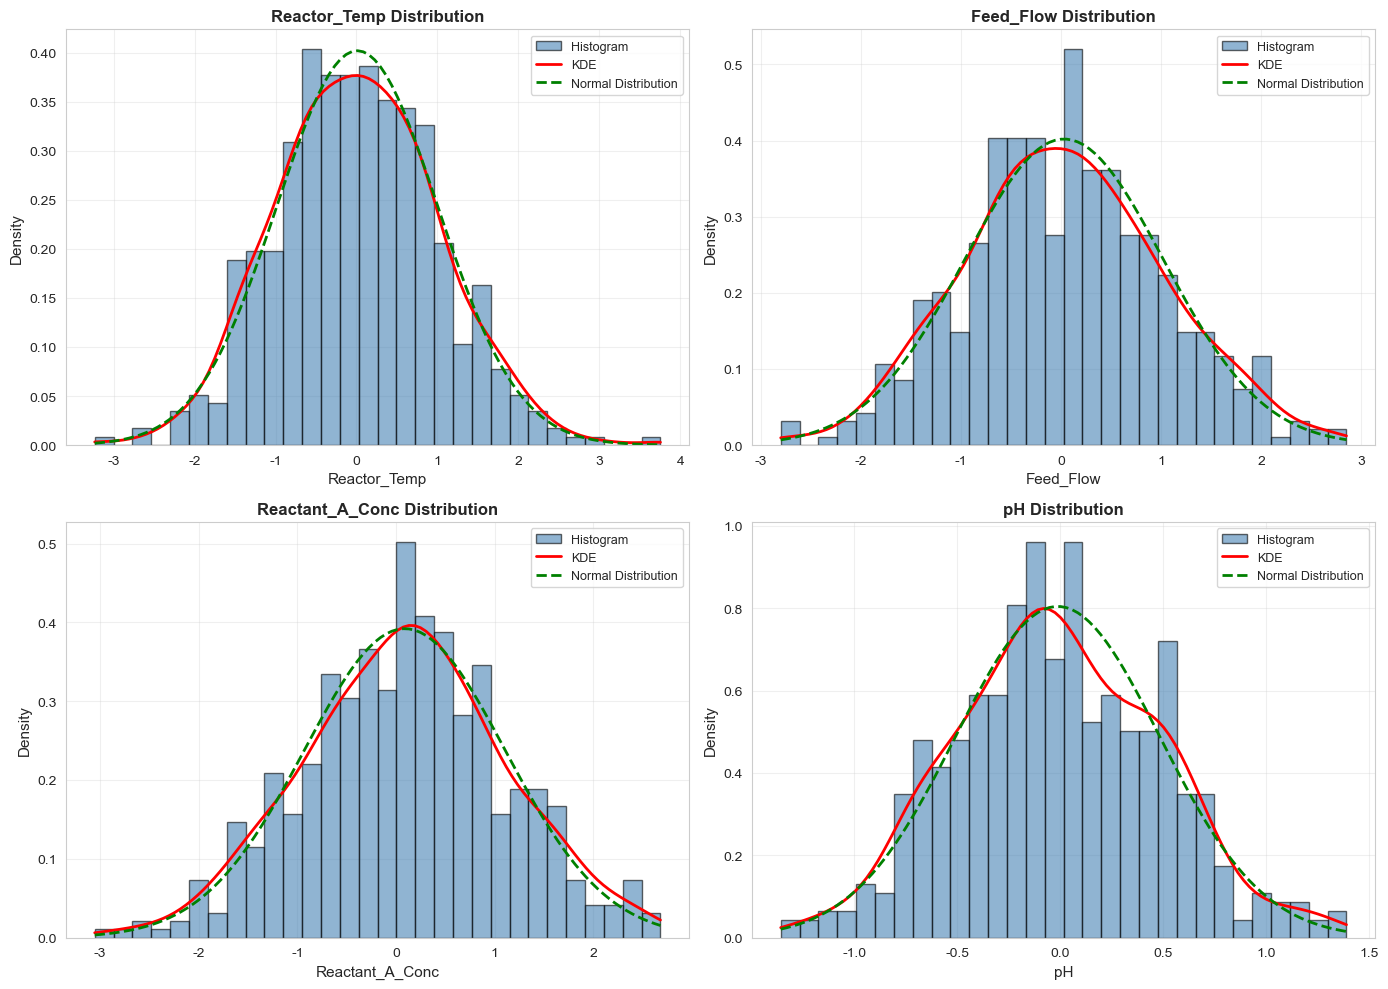

✓ 數據分布視覺化完成
  → 數據大致符合正態分布，適合進行 PCA 分析


In [4]:
# 選擇代表性變數進行分布視覺化
selected_features = ['Reactor_Temp', 'Feed_Flow', 'Reactant_A_Conc', 'pH']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, feat in enumerate(selected_features):
    # 直方圖 + KDE
    axes[i].hist(df_normal[feat], bins=30, alpha=0.6, color='steelblue', 
                 edgecolor='black', density=True, label='Histogram')
    
    # 繪製 KDE 曲線
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(df_normal[feat])
    x_range = np.linspace(df_normal[feat].min(), df_normal[feat].max(), 100)
    axes[i].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    # 正態分布參考線
    mean_val = df_normal[feat].mean()
    std_val = df_normal[feat].std()
    from scipy.stats import norm
    axes[i].plot(x_range, norm.pdf(x_range, mean_val, std_val), 
                 'g--', linewidth=2, label='Normal Distribution')
    
    axes[i].set_xlabel(feat, fontsize=11)
    axes[i].set_ylabel('Density', fontsize=11)
    axes[i].set_title(f'{feat} Distribution', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 數據分布視覺化完成")
print("  → 數據大致符合正態分布，適合進行 PCA 分析")

### 2.2 探索性數據分析 (EDA)

數據統計摘要:
       Reactor_Temp  Jacket_Temp  Product_Temp   Feed_Flow  Coolant_Flow  \
count    500.000000   500.000000    500.000000  500.000000    500.000000   
mean       0.010157     0.003851      0.011742    0.029047      0.022324   
std        0.992436     0.902188      0.759168    0.992458      0.856609   
min       -3.233724    -2.669984     -2.000281   -2.803031     -2.288861   
25%       -0.656171    -0.632341     -0.511821   -0.612550     -0.578108   
50%        0.004048    -0.013280     -0.013052    0.039664     -0.016131   
75%        0.669829     0.616957      0.519645    0.707490      0.592674   
max        3.755279     3.467317      3.165936    2.851691      2.252103   

       Reactant_A_Conc  Reactant_B_Conc  Reactor_Pressure  Feed_Pressure  \
count       500.000000       500.000000        500.000000     500.000000   
mean          0.089678         0.085434          0.009578       0.036487   
std           1.017524         0.865059          0.634642       0.734629   
min

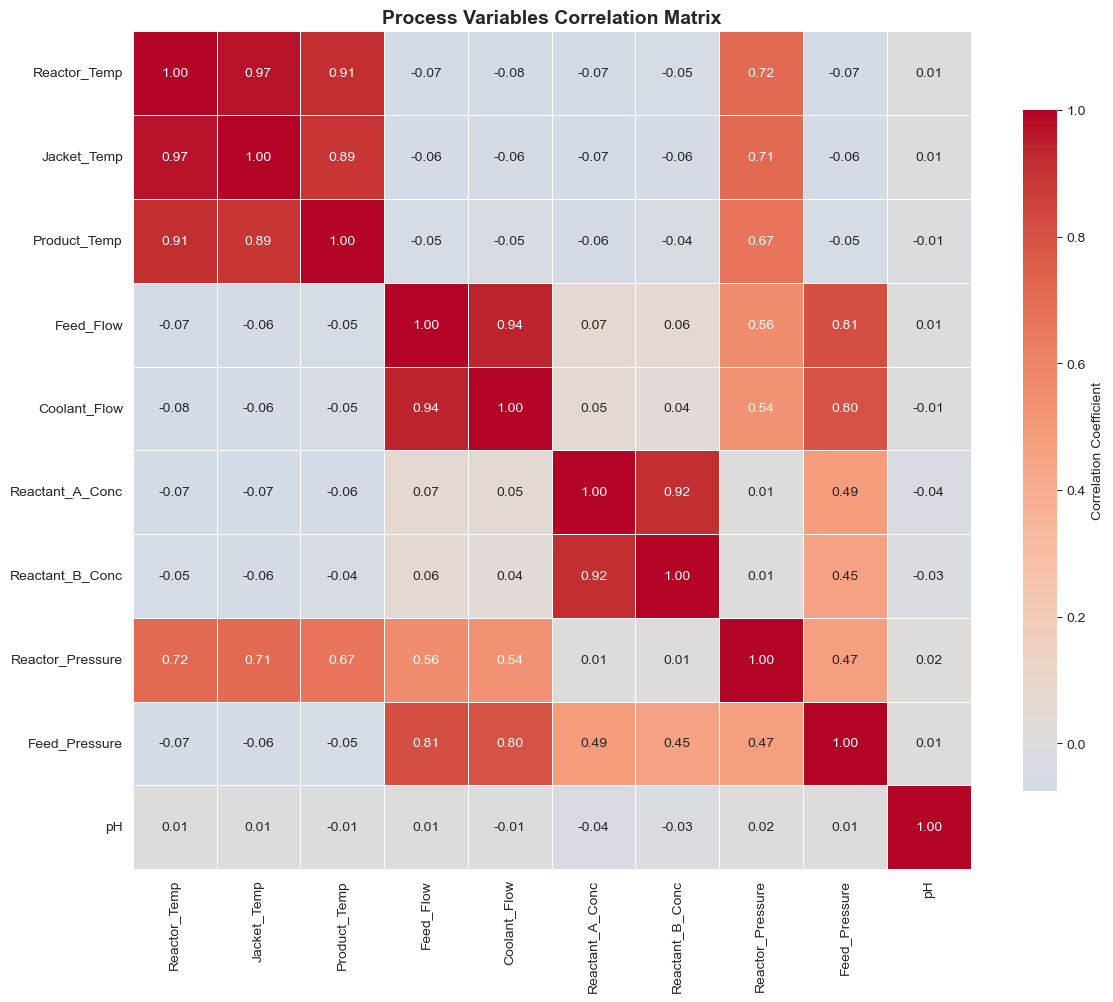


✓ 相關矩陣顯示多個變數間存在高度相關性
  → 適合使用 PCA 進行降維


In [5]:
# 統計描述
print("數據統計摘要:")
print(df_normal[feature_names].describe())

# 檢查缺失值
print(f"\n缺失值檢查:")
print(df_normal[feature_names].isnull().sum())

# 計算相關矩陣
correlation_matrix = df_normal[feature_names].corr()

# 視覺化相關矩陣
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})
plt.title('Process Variables Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 相關矩陣顯示多個變數間存在高度相關性")
print("  → 適合使用 PCA 進行降維")

---
## 3. 數據前處理與標準化

PCA 對特徵尺度敏感，必須先進行標準化處理。

In [6]:
# 分離特徵與標籤
X_train = df_normal[feature_names].values
y_train = df_normal['Label'].values

# 標準化處理
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 檢查標準化結果
print(f"標準化前 - 均值: {X_train.mean(axis=0)[:3]}")
print(f"標準化前 - 標準差: {X_train.std(axis=0)[:3]}")
print(f"\n標準化後 - 均值: {X_train_scaled.mean(axis=0)[:3]}")
print(f"標準化後 - 標準差: {X_train_scaled.std(axis=0)[:3]}")
print(f"\n✓ 數據標準化完成")

標準化前 - 均值: [0.01015679 0.00385092 0.01174203]
標準化前 - 標準差: [0.99144282 0.90128502 0.75840859]

標準化後 - 均值: [ 2.70894418e-17 -7.54951657e-18 -4.30766534e-17]
標準化後 - 標準差: [1. 1. 1.]

✓ 數據標準化完成


---
## 4. PCA 模型建立與訓練

### 4.1 初步 PCA：保留所有主成分

首先執行完整 PCA 以了解數據的變異數分布。

In [7]:
# 建立 PCA 模型（保留所有成分）
pca_full = PCA(random_state=RANDOM_SEED)
X_pca_full = pca_full.fit_transform(X_train_scaled)

# 查看解釋變異數
explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

# 創建解釋變異數表
variance_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(explained_var_ratio))],
    'Explained Variance Ratio': explained_var_ratio,
    'Cumulative Variance Ratio': cumulative_var_ratio
})

print("PCA 解釋變異數分析:")
print(variance_df.to_string(index=False))
print(f"\n✓ 前3個主成分累積解釋變異數: {cumulative_var_ratio[2]:.2%}")
print(f"✓ 前5個主成分累積解釋變異數: {cumulative_var_ratio[4]:.2%}")

PCA 解釋變異數分析:
  PC  Explained Variance Ratio  Cumulative Variance Ratio
 PC1                  0.354985                   0.354985
 PC2                  0.310987                   0.665973
 PC3                  0.186639                   0.852612
 PC4                  0.099930                   0.952542
 PC5                  0.013572                   0.966114
 PC6                  0.011109                   0.977223
 PC7                  0.007810                   0.985033
 PC8                  0.007030                   0.992063
 PC9                  0.005263                   0.997326
PC10                  0.002674                   1.000000

✓ 前3個主成分累積解釋變異數: 85.26%
✓ 前5個主成分累積解釋變異數: 96.61%


### 4.2 視覺化：Scree Plot

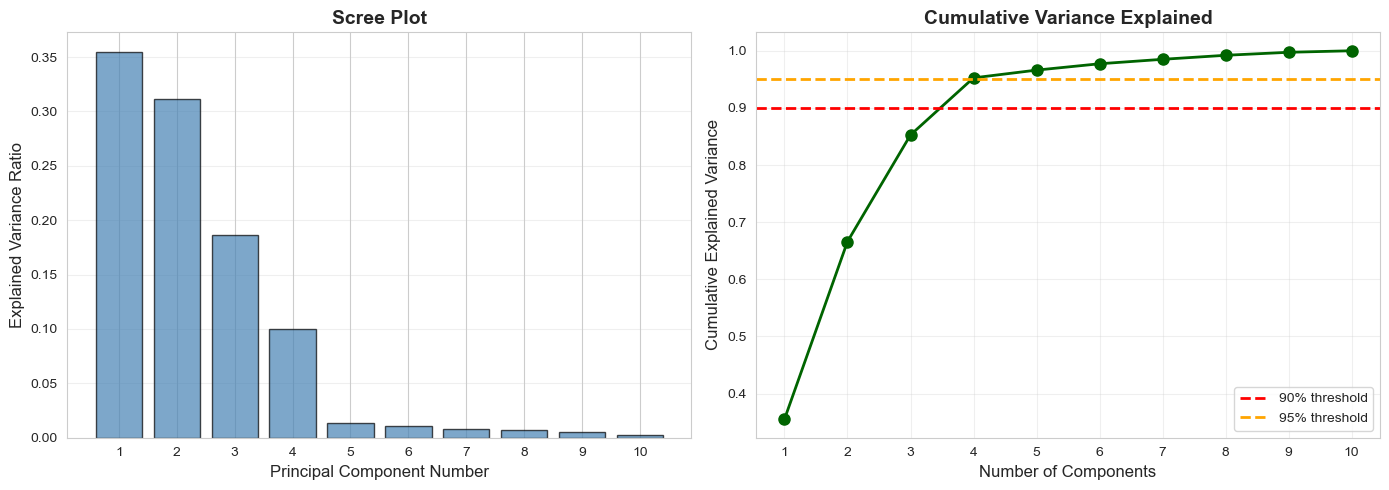

✓ Scree Plot 顯示前幾個主成分貢獻最大
  → 選擇3個主成分可保留 85.3% 變異數


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree Plot
axes[0].bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio, 
            alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component Number', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, len(explained_var_ratio) + 1))
axes[0].grid(axis='y', alpha=0.3)

# Cumulative Variance Plot
axes[1].plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, 
             marker='o', linestyle='-', linewidth=2, markersize=8, color='darkgreen')
axes[1].axhline(y=0.90, color='red', linestyle='--', linewidth=2, label='90% threshold')
axes[1].axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, len(cumulative_var_ratio) + 1))

plt.tight_layout()
plt.savefig(FIG_DIR / 'scree_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Scree Plot 顯示前幾個主成分貢獻最大")
print(f"  → 選擇3個主成分可保留 {cumulative_var_ratio[2]:.1%} 變異數")

### 4.3 最終模型：選擇3個主成分

基於 Scree Plot 分析，我們選擇保留3個主成分（累積解釋變異數 > 90%）。

In [9]:
# 建立最終 PCA 模型
n_components = 3
pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_train_scaled)

print(f"✓ PCA 模型訓練完成")
print(f"  保留主成分數: {pca.n_components_}")
print(f"  累積解釋變異數: {pca.explained_variance_ratio_.sum():.2%}")
print(f"\n各主成分解釋變異數:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.2%}")

✓ PCA 模型訓練完成
  保留主成分數: 3
  累積解釋變異數: 85.26%

各主成分解釋變異數:
  PC1: 35.50%
  PC2: 31.10%
  PC3: 18.66%


---
## 5. Loadings 分析：解釋主成分意義

Loadings 顯示每個原始特徵對主成分的貢獻，幫助我們理解主成分的物理意義。

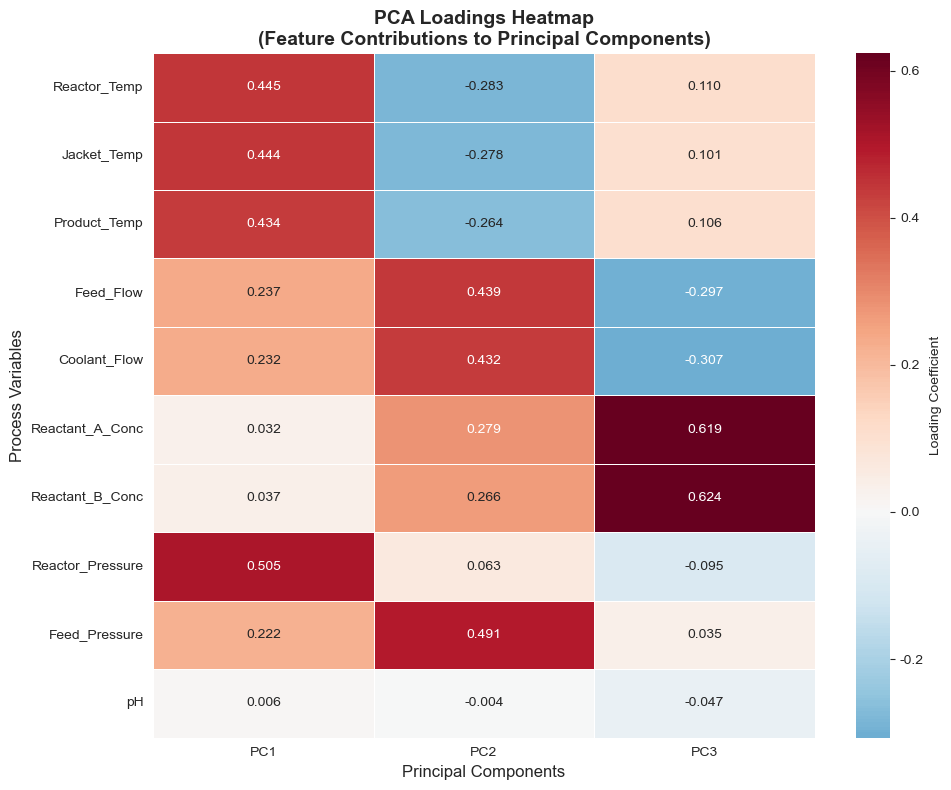

各主成分的主要貢獻變數（Top 3）:

PC1 (解釋 35.5% 變異數):
  Reactor_Pressure    : +0.505
  Reactor_Temp        : +0.445
  Jacket_Temp         : +0.444

PC2 (解釋 31.1% 變異數):
  Feed_Pressure       : +0.491
  Feed_Flow           : +0.439
  Coolant_Flow        : +0.432

PC3 (解釋 18.7% 變異數):
  Reactant_B_Conc     : +0.624
  Reactant_A_Conc     : +0.619
  Coolant_Flow        : -0.307

✓ Loadings 分析完成


In [10]:
# 創建 Loadings DataFrame
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=feature_names
)

# Loadings Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            linewidths=0.5, cbar_kws={'label': 'Loading Coefficient'})
plt.title('PCA Loadings Heatmap\n(Feature Contributions to Principal Components)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Process Variables', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / 'loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印主要貢獻特徵
print("各主成分的主要貢獻變數（Top 3）:")
for i in range(n_components):
    pc_name = f'PC{i+1}'
    top_features = loadings[pc_name].abs().nlargest(3)
    print(f"\n{pc_name} (解釋 {pca.explained_variance_ratio_[i]:.1%} 變異數):")
    for feat, _ in top_features.items():
        loading_val = loadings.loc[feat, pc_name]
        print(f"  {feat:20s}: {loading_val:+.3f}")

print("\n✓ Loadings 分析完成")

### 5.1 Loading Plot：向量圖

Loading Plot 以向量形式展示原始變數在主成分空間中的方向與強度。

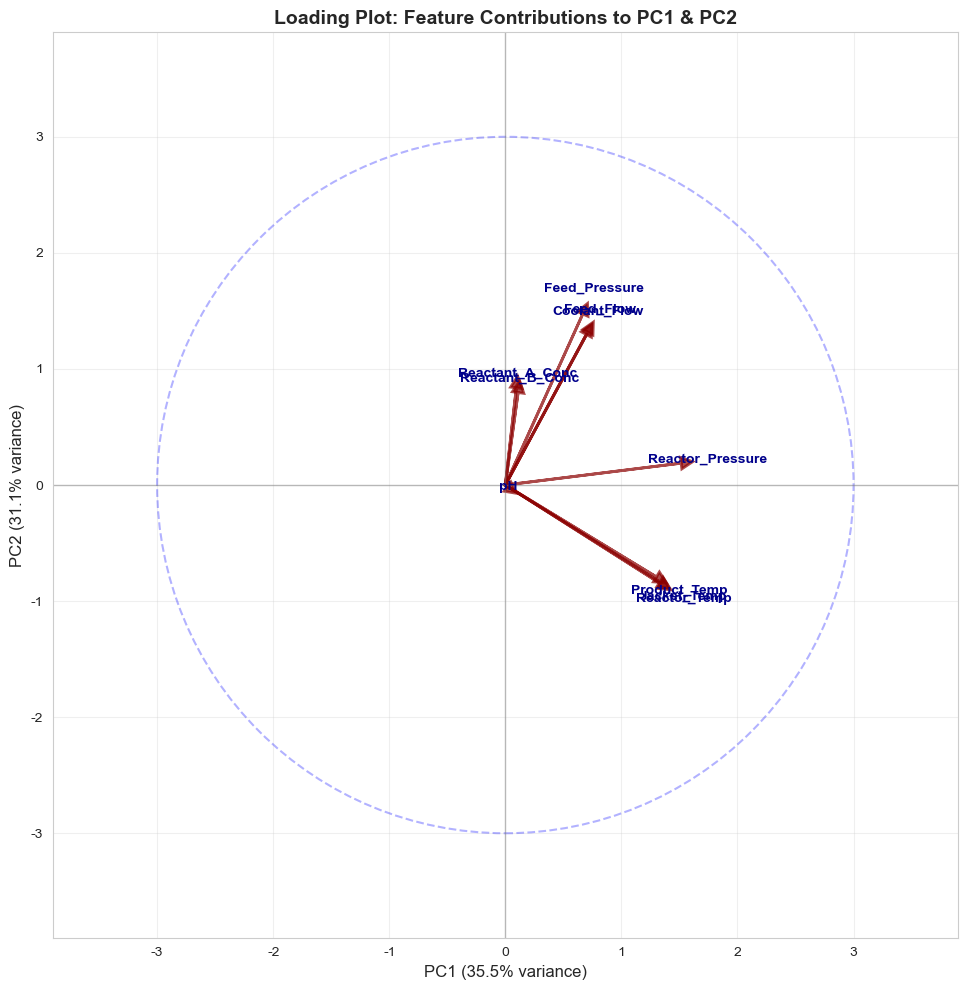

✓ Loading Plot 完成
  → 向量長度代表貢獻度，方向代表相關性


In [11]:
# Loading Plot (PC1 vs PC2)
fig, ax = plt.subplots(figsize=(10, 10))

# 繪製主成分軸
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

# 繪製 Loading 向量
scale_factor = 3  # 放大因子以便視覺化
for i, feature in enumerate(feature_names):
    x = loadings.loc[feature, 'PC1'] * scale_factor
    y = loadings.loc[feature, 'PC2'] * scale_factor
    
    # 繪製箭頭
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, 
             fc='darkred', ec='darkred', linewidth=2, alpha=0.7)
    
    # 標註特徵名稱
    ax.text(x * 1.15, y * 1.15, feature, fontsize=10, 
            ha='center', va='center', color='darkblue', fontweight='bold')

# 繪製單位圓
circle = plt.Circle((0, 0), scale_factor, color='blue', fill=False, 
                     linestyle='--', linewidth=1.5, alpha=0.3)
ax.add_patch(circle)

ax.set_xlim(-scale_factor * 1.3, scale_factor * 1.3)
ax.set_ylim(-scale_factor * 1.3, scale_factor * 1.3)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Loading Plot: Feature Contributions to PC1 & PC2', 
             fontsize=14, fontweight='bold')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'loading_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Loading Plot 完成")
print("  → 向量長度代表貢獻度，方向代表相關性")

### 5.2 Biplot：結合 Scores 與 Loadings

Biplot 同時展示樣本分布（Scores）與變數貢獻（Loadings），是 PCA 最常用的綜合視覺化工具。

**視覺標記系統**：
- 🔴 **紅色星號 (⭐)**：T² 最大異常樣本（主成分空間內系統性偏移）
- 🟠 **橙色菱形 (◆)**：SPE 最大異常樣本（PCA 模型外的新型態變異）
- 此標記系統將貫穿所有後續視覺化圖表，方便追蹤異常樣本

In [12]:
# === 提前計算 T² 和 SPE 統計量（用於後續視覺化標記） ===

# 定義統計量計算函數
def compute_T2(scores, eigenvalues):
    """計算 Hotelling's T² 統計量"""
    return np.sum((scores ** 2) / eigenvalues, axis=1)

def compute_SPE(X_original, X_reconstructed):
    """計算 SPE (Squared Prediction Error)"""
    residuals = X_original - X_reconstructed
    return np.sum(residuals ** 2, axis=1)

# 重建數據
X_reconstructed = pca.inverse_transform(X_pca)

# 計算統計量
T2_train = compute_T2(X_pca, pca.explained_variance_)
SPE_train = compute_SPE(X_train_scaled, X_reconstructed)

# 計算控制限（95% 信賴水準）
alpha = 0.05
n = len(X_train_scaled)
k = n_components

# T² 控制限
T2_limit = (k * (n - 1) / (n - k)) * f.ppf(1 - alpha, k, n - k)

# SPE 控制限（使用樣本的第95百分位數）
SPE_limit = np.percentile(SPE_train, 95)

# 選擇 T² 和 SPE 最大的樣本（用於異常標記）
max_T2_idx = np.argmax(T2_train) if len(T2_train) > 0 else None
max_SPE_idx = np.argmax(SPE_train) if len(SPE_train) > 0 else None

print(f"✓ 統計量計算完成（用於異常樣本標記）")
if max_T2_idx is not None:
    print(f"  T² 最大樣本: {max_T2_idx} (值: {T2_train[max_T2_idx]:.3f})")
if max_SPE_idx is not None:
    print(f"  SPE 最大樣本: {max_SPE_idx} (值: {SPE_train[max_SPE_idx]:.3f})")

✓ 統計量計算完成（用於異常樣本標記）
  T² 最大樣本: 209 (值: 23.389)
  SPE 最大樣本: 194 (值: 9.063)


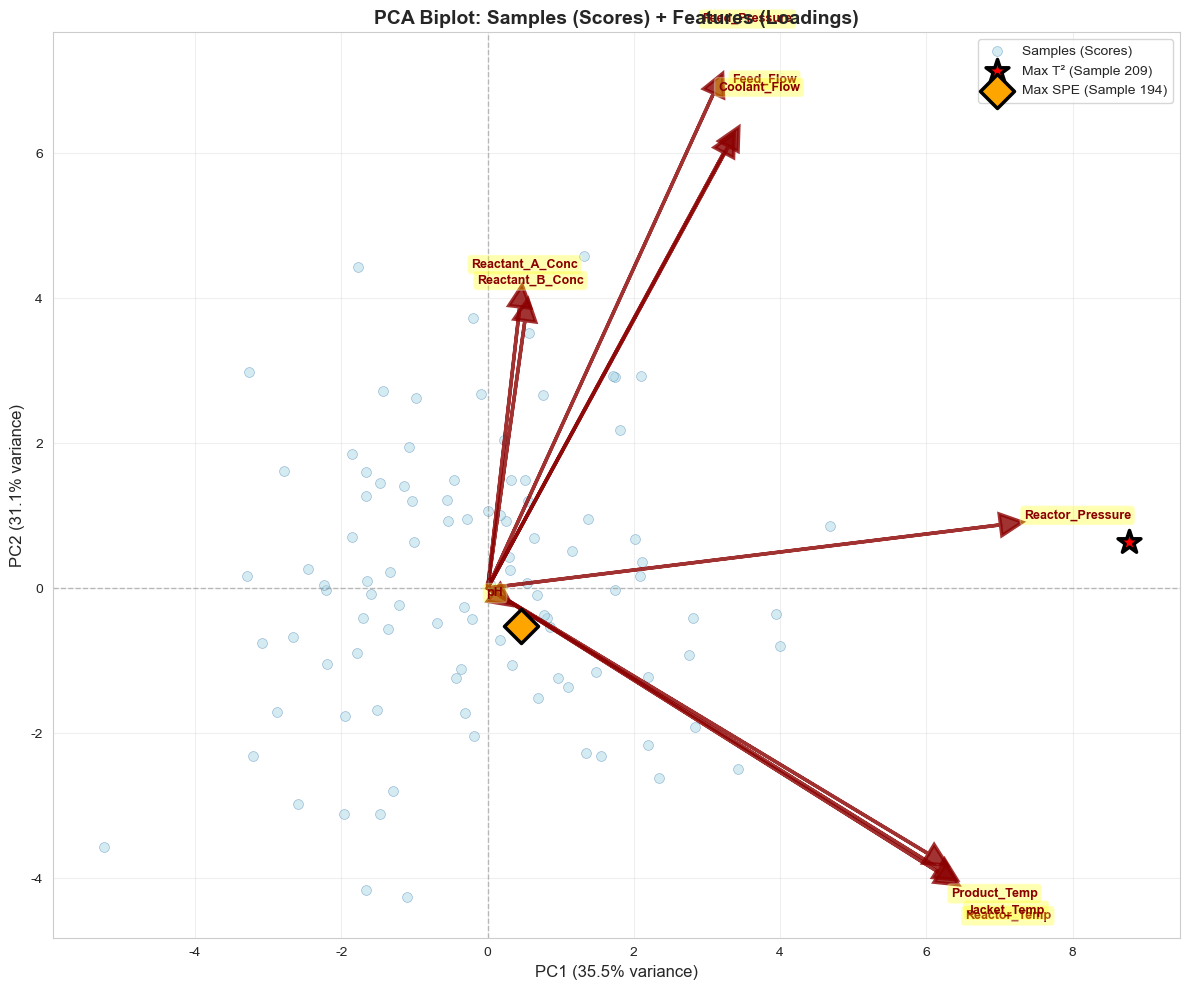

✓ Biplot 完成
  → 藍色點：樣本投影（Scores）
  → 紅色箭頭：特徵向量（Loadings）
  → 紅色星號：T² 最大異常樣本
  → 橙色菱形：SPE 最大異常樣本


In [13]:
# Biplot (PC1 vs PC2)
fig, ax = plt.subplots(figsize=(12, 10))

# === 繪製 Scores (樣本點) ===
# 使用子樣本避免過度擁擠
sample_indices = np.random.choice(len(X_pca), size=100, replace=False)
ax.scatter(X_pca[sample_indices, 0], X_pca[sample_indices, 1], 
           c='lightblue', alpha=0.5, s=50, edgecolors='steelblue', 
           linewidth=0.5, label='Samples (Scores)')

# === 繪製 Loadings (特徵向量) ===
# 需要縮放以匹配 scores 的尺度
score_scale = np.max(np.abs(X_pca[:, :2]))  # scores 的最大值
loading_scale = np.max(np.abs(loadings.iloc[:, :2].values))  # loadings 的最大值
scale_factor = score_scale / loading_scale * 0.8  # 調整因子

for i, feature in enumerate(feature_names):
    x = loadings.loc[feature, 'PC1'] * scale_factor
    y = loadings.loc[feature, 'PC2'] * scale_factor
    
    # 繪製箭頭
    ax.arrow(0, 0, x, y, head_width=0.3, head_length=0.3,
             fc='darkred', ec='darkred', linewidth=2.5, alpha=0.8)
    
    # 標註特徵名稱（位置微調避免重疊）
    ax.text(x * 1.15, y * 1.15, feature, fontsize=9,
            ha='center', va='center', color='darkred', 
            fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', 
                                         facecolor='yellow', alpha=0.3))

# === 標記異常樣本 ===
if max_T2_idx is not None:
    ax.scatter([X_pca[max_T2_idx, 0]], [X_pca[max_T2_idx, 1]], 
               color='red', s=300, marker='*', edgecolors='black', 
               linewidth=2.5, zorder=10, label=f'Max T² (Sample {max_T2_idx})')
if max_SPE_idx is not None and max_SPE_idx != max_T2_idx:
    ax.scatter([X_pca[max_SPE_idx, 0]], [X_pca[max_SPE_idx, 1]], 
               color='orange', s=300, marker='D', edgecolors='black', 
               linewidth=2.5, zorder=10, label=f'Max SPE (Sample {max_SPE_idx})')

# 繪製原點參考線
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('PCA Biplot: Samples (Scores) + Features (Loadings)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'biplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Biplot 完成")
print("  → 藍色點：樣本投影（Scores）")
print("  → 紅色箭頭：特徵向量（Loadings）")
print("  → 紅色星號：T² 最大異常樣本")
print("  → 橙色菱形：SPE 最大異常樣本")

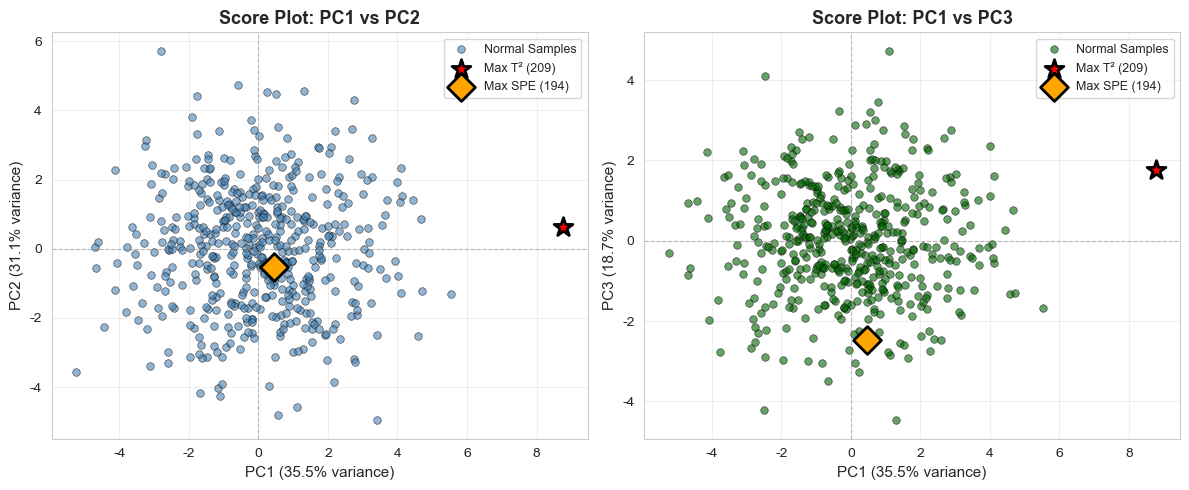

✓ Score Plot 完成（已標記最大異常樣本）


In [14]:
# 2D Score Plot
fig = plt.figure(figsize=(12, 5))

# PC1 vs PC2
ax1 = fig.add_subplot(121)
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c='steelblue', alpha=0.6, 
                      s=30, edgecolors='black', linewidth=0.5, label='Normal Samples')

# 標記異常樣本
if max_T2_idx is not None:
    ax1.scatter([X_pca[max_T2_idx, 0]], [X_pca[max_T2_idx, 1]], 
                color='red', s=200, marker='*', edgecolors='black', 
                linewidth=2, zorder=5, label=f'Max T² ({max_T2_idx})')
if max_SPE_idx is not None and max_SPE_idx != max_T2_idx:
    ax1.scatter([X_pca[max_SPE_idx, 0]], [X_pca[max_SPE_idx, 1]], 
                color='orange', s=200, marker='D', edgecolors='black', 
                linewidth=2, zorder=5, label=f'Max SPE ({max_SPE_idx})')

ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('Score Plot: PC1 vs PC2', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9, loc='best')
ax1.grid(True, alpha=0.3)

# PC1 vs PC3
ax2 = fig.add_subplot(122)
scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 2], c='darkgreen', alpha=0.6,
                      s=30, edgecolors='black', linewidth=0.5, label='Normal Samples')

# 標記異常樣本
if max_T2_idx is not None:
    ax2.scatter([X_pca[max_T2_idx, 0]], [X_pca[max_T2_idx, 2]], 
                color='red', s=200, marker='*', edgecolors='black', 
                linewidth=2, zorder=5, label=f'Max T² ({max_T2_idx})')
if max_SPE_idx is not None and max_SPE_idx != max_T2_idx:
    ax2.scatter([X_pca[max_SPE_idx, 0]], [X_pca[max_SPE_idx, 2]], 
                color='orange', s=200, marker='D', edgecolors='black', 
                linewidth=2, zorder=5, label=f'Max SPE ({max_SPE_idx})')

ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax2.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)', fontsize=11)
ax2.set_title('Score Plot: PC1 vs PC3', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'score_plot_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Score Plot 完成（已標記最大異常樣本）")

### 5.3 Score Plot：主成分空間樣本分布

Score Plot 展示樣本在主成分空間的投影，可用於視覺化樣本分布、識別異常樣本與群集結構。

---
## 6. 製程監控：T² 和 SPE 控制圖

建立 Hotelling's T² 和 SPE (Q) 統計量控制圖，用於即時監控製程是否偏離正常操作。


異常檢測結果:
  T² 超限樣本數: 20 (4.0%)
  SPE 超限樣本數: 25 (5.0%)
  理論誤報率 (α=0.05): 5.0%

  T² 最大異常樣本:
    索引: 209, T² 值: 23.389 (控制限: 7.900)
  SPE 最大異常樣本:
    索引: 194, SPE 值: 9.063 (控制限: 4.289)


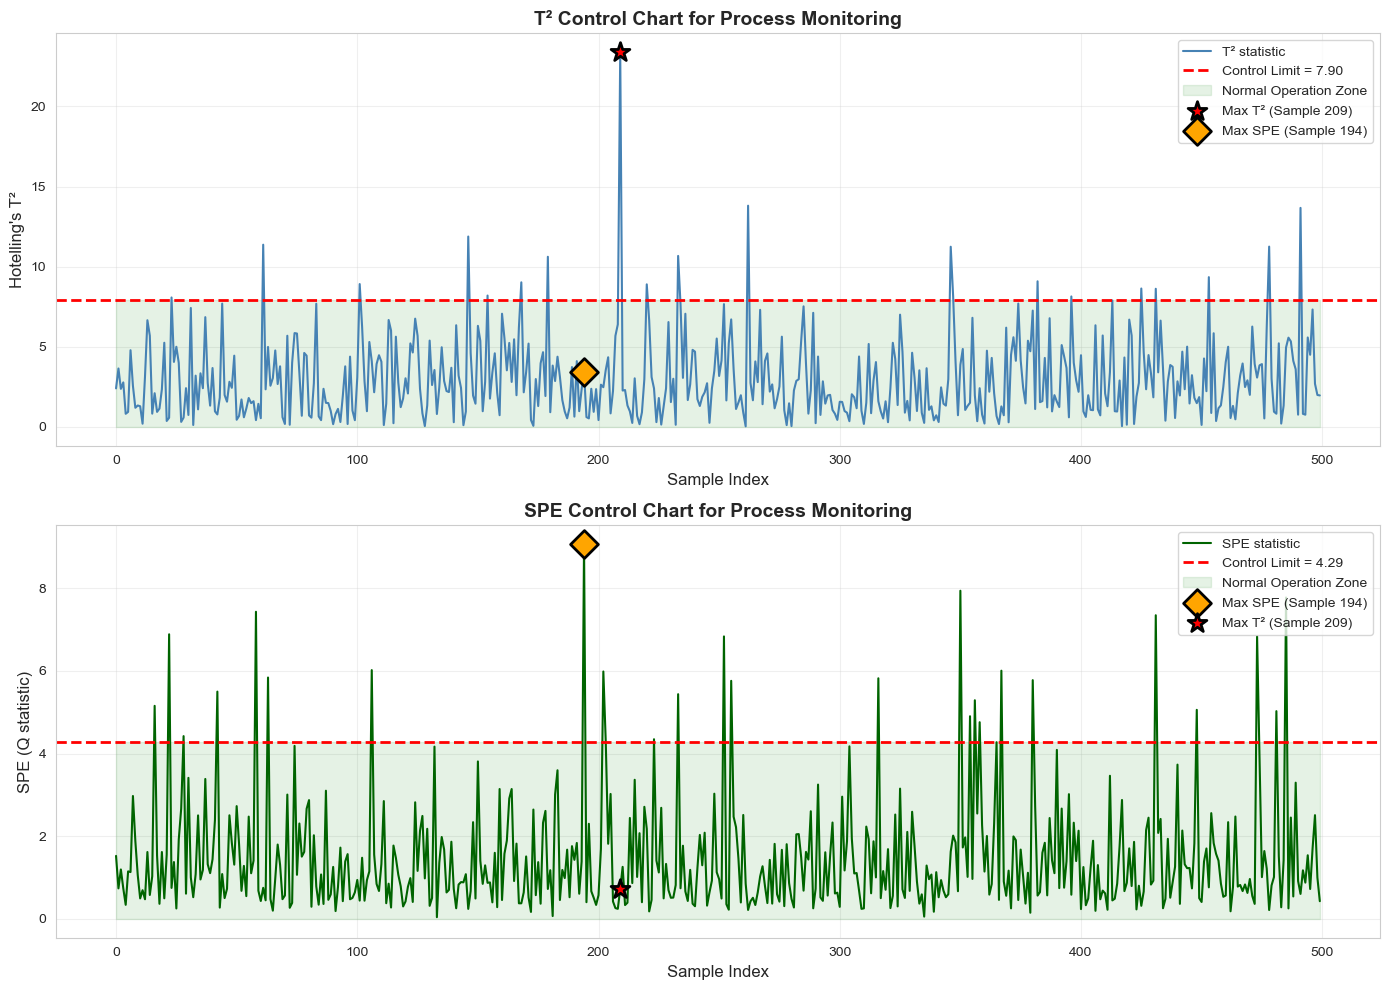


✓ 控制圖繪製完成（已標記最大異常樣本）


In [15]:
# 檢測異常樣本
anomalies_T2 = np.where(T2_train > T2_limit)[0]
anomalies_SPE = np.where(SPE_train > SPE_limit)[0]

# 選擇 T² 和 SPE 超限最大的樣本
max_T2_idx = np.argmax(T2_train) if len(T2_train) > 0 else None
max_SPE_idx = np.argmax(SPE_train) if len(SPE_train) > 0 else None

print(f"\n異常檢測結果:")
print(f"  T² 超限樣本數: {len(anomalies_T2)} ({len(anomalies_T2)/len(T2_train)*100:.1f}%)")
print(f"  SPE 超限樣本數: {len(anomalies_SPE)} ({len(anomalies_SPE)/len(SPE_train)*100:.1f}%)")
print(f"  理論誤報率 (α=0.05): 5.0%")

if max_T2_idx is not None:
    print(f"\n  T² 最大異常樣本:")
    print(f"    索引: {max_T2_idx}, T² 值: {T2_train[max_T2_idx]:.3f} (控制限: {T2_limit:.3f})")
if max_SPE_idx is not None:
    print(f"  SPE 最大異常樣本:")
    print(f"    索引: {max_SPE_idx}, SPE 值: {SPE_train[max_SPE_idx]:.3f} (控制限: {SPE_limit:.3f})")

# 繪製控制圖
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# T² 控制圖
axes[0].plot(T2_train, linewidth=1.5, label='T² statistic', color='steelblue')
axes[0].axhline(y=T2_limit, color='red', linestyle='--', linewidth=2, 
                label=f'Control Limit = {T2_limit:.2f}')
axes[0].fill_between(range(len(T2_train)), 0, T2_limit, alpha=0.1, color='green', 
                      label='Normal Operation Zone')

# 標記 T² 最大異常點
if max_T2_idx is not None:
    axes[0].scatter([max_T2_idx], [T2_train[max_T2_idx]], 
                    color='red', s=200, marker='*', edgecolors='black', 
                    linewidth=2, zorder=5, label=f'Max T² (Sample {max_T2_idx})')
# 標記 SPE 最大異常點（在 T² 圖中也顯示）
if max_SPE_idx is not None:
    axes[0].scatter([max_SPE_idx], [T2_train[max_SPE_idx]], 
                    color='orange', s=200, marker='D', edgecolors='black', 
                    linewidth=2, zorder=5, label=f'Max SPE (Sample {max_SPE_idx})')

axes[0].set_xlabel('Sample Index', fontsize=12)
axes[0].set_ylabel('Hotelling\'s T²', fontsize=12)
axes[0].set_title('T² Control Chart for Process Monitoring', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10, loc='upper right')
axes[0].grid(True, alpha=0.3)

# SPE 控制圖
axes[1].plot(SPE_train, linewidth=1.5, label='SPE statistic', color='darkgreen')
axes[1].axhline(y=SPE_limit, color='red', linestyle='--', linewidth=2, 
                label=f'Control Limit = {SPE_limit:.2f}')
axes[1].fill_between(range(len(SPE_train)), 0, SPE_limit, alpha=0.1, color='green',
                      label='Normal Operation Zone')

# 標記 SPE 最大異常點
if max_SPE_idx is not None:
    axes[1].scatter([max_SPE_idx], [SPE_train[max_SPE_idx]], 
                    color='orange', s=200, marker='D', edgecolors='black', 
                    linewidth=2, zorder=5, label=f'Max SPE (Sample {max_SPE_idx})')
# 標記 T² 最大異常點（在 SPE 圖中也顯示）
if max_T2_idx is not None:
    axes[1].scatter([max_T2_idx], [SPE_train[max_T2_idx]], 
                    color='red', s=200, marker='*', edgecolors='black', 
                    linewidth=2, zorder=5, label=f'Max T² (Sample {max_T2_idx})')

axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('SPE (Q statistic)', fontsize=12)
axes[1].set_title('SPE Control Chart for Process Monitoring', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'control_charts.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 控制圖繪製完成（已標記最大異常樣本）")

### 6.1 Contribution Plot：故障變數診斷

當偵測到異常樣本時，Contribution Plot 可幫助定位造成異常的主要變數。


開始故障診斷分析：比較 T² 最大 vs SPE 最大異常樣本

【T² Max】 Sample Index: 209
  T² 值: 23.389 (控制限: 7.900) - 超限
  SPE 值: 0.723 (控制限: 4.289) - 正常


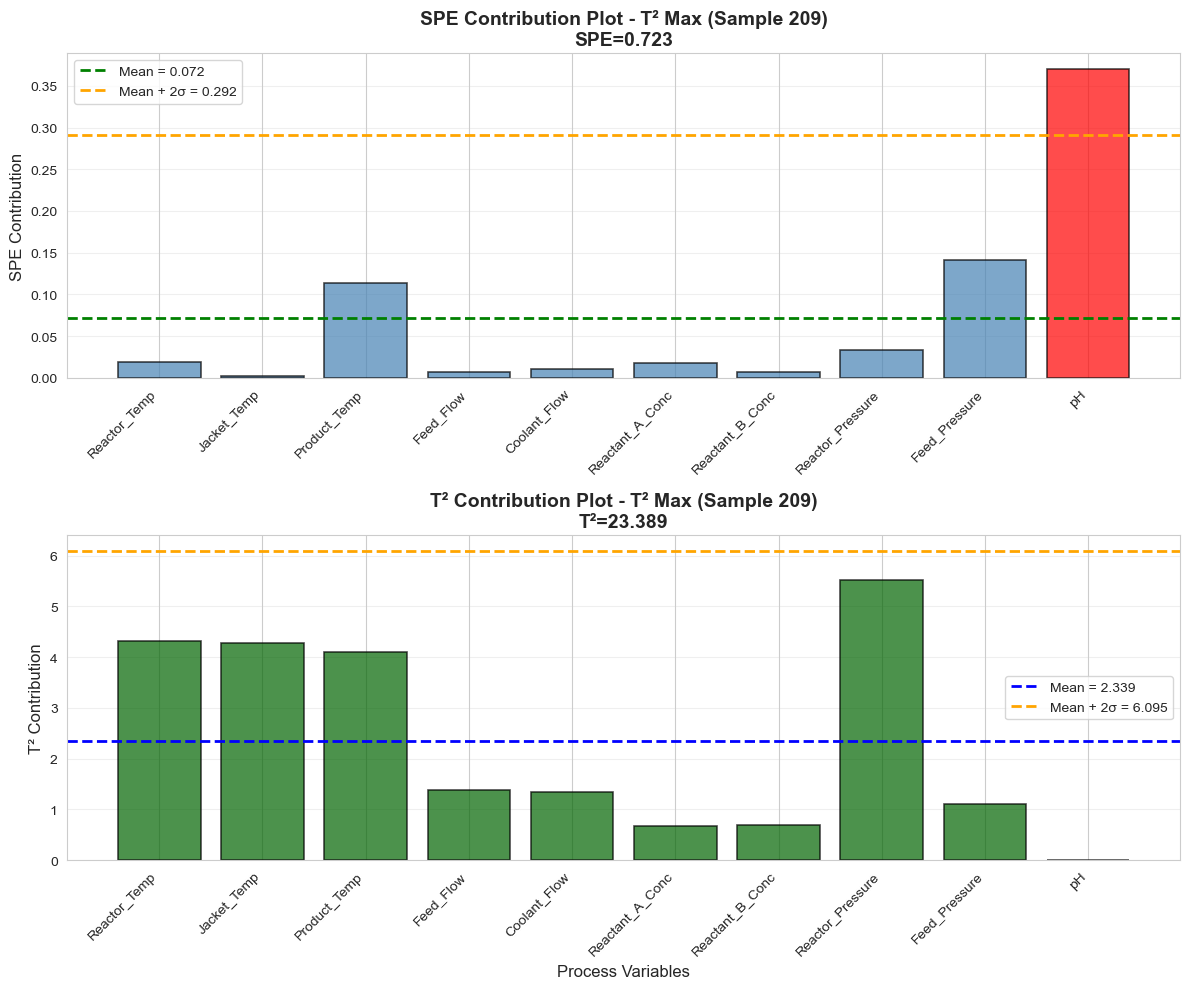


=== SPE 主要貢獻變數 (Top 3) ===
  pH                  : 0.3707
  Feed_Pressure       : 0.1415
  Product_Temp        : 0.1142

=== T² 主要貢獻變數 (Top 3) ===
  Reactor_Pressure    : 5.5195
  Reactor_Temp        : 4.3111
  Jacket_Temp         : 4.2810

【SPE Max】 Sample Index: 194
  T² 值: 3.406 (控制限: 7.900) - 正常
  SPE 值: 9.063 (控制限: 4.289) - 超限


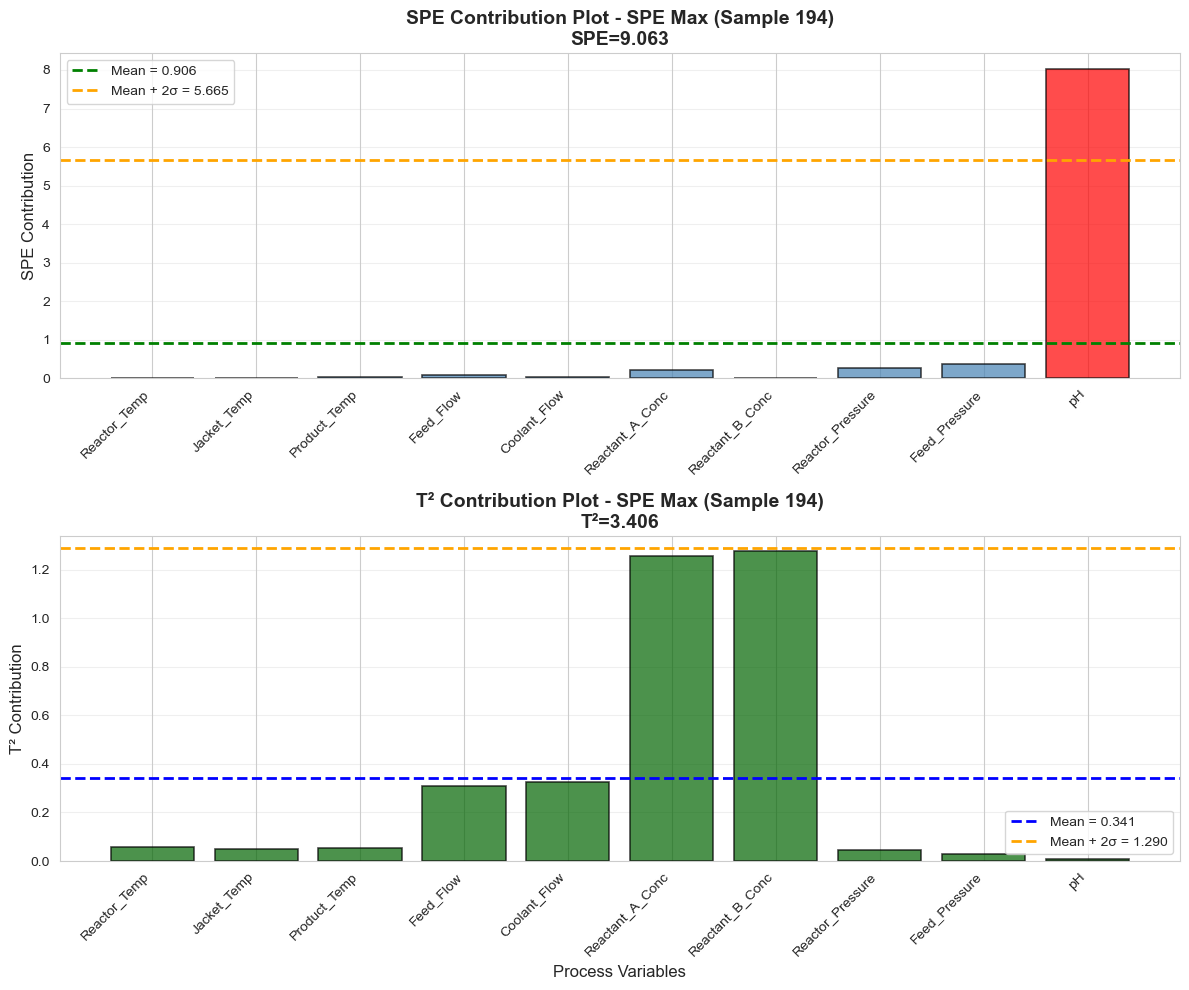


=== SPE 主要貢獻變數 (Top 3) ===
  pH                  : 8.0346
  Feed_Pressure       : 0.3707
  Reactor_Pressure    : 0.2691

=== T² 主要貢獻變數 (Top 3) ===
  Reactant_B_Conc     : 1.2750
  Reactant_A_Conc     : 1.2545
  Coolant_Flow        : 0.3266

✓ Contribution Plot 分析完成
  → 紅色柱：超過 Mean + 2σ 的異常貢獻變數
  → T² Max 樣本：顯示主成分空間內的系統性偏移
  → SPE Max 樣本：顯示 PCA 模型無法解釋的異常變異


In [16]:
# 計算每個變數對 SPE 的貢獻
residuals = X_train_scaled - X_reconstructed
spe_contributions = residuals ** 2

# 分析兩個關鍵異常樣本：T² 最大 和 SPE 最大
anomaly_samples = []
if max_T2_idx is not None:
    anomaly_samples.append(('T² Max', max_T2_idx, 'red', '*'))
if max_SPE_idx is not None and max_SPE_idx != max_T2_idx:
    anomaly_samples.append(('SPE Max', max_SPE_idx, 'orange', 'D'))

if len(anomaly_samples) > 0:
    print(f"\n{'='*60}")
    print(f"開始故障診斷分析：比較 T² 最大 vs SPE 最大異常樣本")
    print(f"{'='*60}")
    
    # 為每個異常樣本繪製貢獻圖
    for sample_name, anomaly_idx, color, marker in anomaly_samples:
        print(f"\n{'='*60}")
        print(f"【{sample_name}】 Sample Index: {anomaly_idx}")
        print(f"  T² 值: {T2_train[anomaly_idx]:.3f} (控制限: {T2_limit:.3f}) - {'超限' if T2_train[anomaly_idx] > T2_limit else '正常'}")
        print(f"  SPE 值: {SPE_train[anomaly_idx]:.3f} (控制限: {SPE_limit:.3f}) - {'超限' if SPE_train[anomaly_idx] > SPE_limit else '正常'}")
        print(f"{'='*60}")
        
        # 該樣本的 SPE 貢獻度
        contributions = spe_contributions[anomaly_idx]
        
        # 繪製貢獻圖
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))
        
        # === 子圖 1: SPE 貢獻柱狀圖 ===
        colors_spe = ['red' if c > contributions.mean() + 2*contributions.std() 
                  else 'steelblue' for c in contributions]
        
        axes[0].bar(feature_names, contributions, color=colors_spe, 
                    edgecolor='black', linewidth=1.2, alpha=0.7)
        axes[0].axhline(y=contributions.mean(), color='green', linestyle='--', 
                        linewidth=2, label=f'Mean = {contributions.mean():.3f}')
        axes[0].axhline(y=contributions.mean() + 2*contributions.std(), 
                        color='orange', linestyle='--', linewidth=2, 
                        label=f'Mean + 2σ = {contributions.mean() + 2*contributions.std():.3f}')
        axes[0].set_ylabel('SPE Contribution', fontsize=12)
        axes[0].set_title(f'SPE Contribution Plot - {sample_name} (Sample {anomaly_idx})\nSPE={SPE_train[anomaly_idx]:.3f}', 
                          fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(axis='y', alpha=0.3)
        axes[0].set_xticklabels(feature_names, rotation=45, ha='right')
        
        # === 子圖 2: T² 貢獻柱狀圖 ===
        # 計算 T² 貢獻（每個變數對 T² 的貢獻）
        scores = X_pca[anomaly_idx]
        t2_contributions_pc = (scores ** 2) / pca.explained_variance_
        
        # 反推至原始變數空間
        t2_contributions_features = np.zeros(n_features)
        for i in range(n_features):
            for j in range(n_components):
                t2_contributions_features[i] += (loadings.iloc[i, j] ** 2) * t2_contributions_pc[j]
        
        colors_t2 = ['red' if c > t2_contributions_features.mean() + 2*t2_contributions_features.std() 
                     else 'darkgreen' for c in t2_contributions_features]
        
        axes[1].bar(feature_names, t2_contributions_features, color=colors_t2,
                    edgecolor='black', linewidth=1.2, alpha=0.7)
        axes[1].axhline(y=t2_contributions_features.mean(), color='blue', 
                        linestyle='--', linewidth=2, 
                        label=f'Mean = {t2_contributions_features.mean():.3f}')
        axes[1].axhline(y=t2_contributions_features.mean() + 2*t2_contributions_features.std(),
                        color='orange', linestyle='--', linewidth=2,
                        label=f'Mean + 2σ = {t2_contributions_features.mean() + 2*t2_contributions_features.std():.3f}')
        axes[1].set_xlabel('Process Variables', fontsize=12)
        axes[1].set_ylabel('T² Contribution', fontsize=12)
        axes[1].set_title(f'T² Contribution Plot - {sample_name} (Sample {anomaly_idx})\nT²={T2_train[anomaly_idx]:.3f}', 
                          fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(axis='y', alpha=0.3)
        axes[1].set_xticklabels(feature_names, rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig(FIG_DIR / f'contribution_plot_sample_{anomaly_idx}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 打印主要貢獻變數
        print(f"\n=== SPE 主要貢獻變數 (Top 3) ===")
        spe_top_idx = np.argsort(contributions)[::-1][:3]
        for idx in spe_top_idx:
            print(f"  {feature_names[idx]:20s}: {contributions[idx]:.4f}")
        
        print(f"\n=== T² 主要貢獻變數 (Top 3) ===")
        t2_top_idx = np.argsort(t2_contributions_features)[::-1][:3]
        for idx in t2_top_idx:
            print(f"  {feature_names[idx]:20s}: {t2_contributions_features[idx]:.4f}")
    
    print(f"\n{'='*60}")
    print("✓ Contribution Plot 分析完成")
    print("  → 紅色柱：超過 Mean + 2σ 的異常貢獻變數")
    print("  → T² Max 樣本：顯示主成分空間內的系統性偏移")
    print("  → SPE Max 樣本：顯示 PCA 模型無法解釋的異常變異")
    print(f"{'='*60}")
else:
    print("⚠️ 未偵測到異常樣本，無法繪製 Contribution Plot")

---
## 7. 模型儲存

儲存訓練好的 Scaler 和 PCA 模型，供後續使用。

In [17]:
import joblib

# 儲存模型
joblib.dump(scaler, MODEL_DIR / 'scaler.pkl')
joblib.dump(pca, MODEL_DIR / 'pca_model.pkl')

# 儲存控制限
control_limits = {
    'T2_limit': T2_limit,
    'SPE_limit': SPE_limit,
    'alpha': alpha
}
joblib.dump(control_limits, MODEL_DIR / 'control_limits.pkl')

print("✓ 模型儲存完成")
print(f"  Scaler: {MODEL_DIR / 'scaler.pkl'}")
print(f"  PCA Model: {MODEL_DIR / 'pca_model.pkl'}")
print(f"  Control Limits: {MODEL_DIR / 'control_limits.pkl'}")

✓ 模型儲存完成
  Scaler: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_PCA\models\scaler.pkl
  PCA Model: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_PCA\models\pca_model.pkl
  Control Limits: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_PCA\models\control_limits.pkl


---
## 8. 課程總結

### 本單元學習重點

✅ **PCA 核心概念**：
- PCA 是線性降維技術，透過特徵值分解找出數據主要變異方向
- 主成分彼此正交，依解釋變異數大小排序
- 可將高維數據降至低維，同時保留大部分信息

✅ **主成分數量選擇**：
- 使用 Scree Plot 觀察"肘點"
- 根據累積解釋變異數設定閾值（如 90%、95%）
- 結合化工領域知識判斷

✅ **Loadings 與 Scores**：
- **Loadings**：原始特徵對主成分的貢獻係數，用於解釋主成分意義
- **Scores**：樣本在主成分空間的投影座標，用於視覺化與監控

✅ **進階視覺化技術**：
- **Loading Plot**：向量圖展示特徵在主成分空間的方向與強度
- **Biplot**：同時展示樣本與特徵的綜合視圖
- **Contribution Plot**：故障診斷時定位異常貢獻變數

✅ **製程監控應用**：
- **T² 統計量**：監控主成分空間內的偏移（系統性變化）
- **SPE 統計量**：監控 PCA 模型外的變異（新型態異常）
- 設定控制限（通常 95% 或 99% 信賴水準）

✅ **實務考量**：
- 數據必須標準化（特徵尺度差異大時）
- 僅使用正常操作數據訓練 PCA
- PCA 僅捕捉線性關係，高度非線性製程考慮 Kernel PCA

### 化工領域應用價值

- **製程監控**：即時監控多變數製程，快速檢測異常
- **故障診斷**：透過貢獻圖定位故障變數
- **數據視覺化**：將高維製程數據降至 2D/3D 空間
- **降維建模**：作為預測模型的前處理步驟，消除共線性

### 下一步學習

完成本單元後，建議繼續學習：
- **Unit06_Kernel_PCA**：非線性降維方法
- **Unit06_tSNE**：高維數據視覺化（保持局部結構）
- **Unit06_UMAP**：大規模數據降維與視覺化

---

**完成時間記錄**: {記錄您的學習時間}